# Imports

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

from torch.utils.data import Sampler
import numpy as np
import random
from collections import defaultdict
import csv
import os
import json
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math
from torch.utils.data import Sampler, DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix



device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Inputs

In [56]:
#shape (Num, Channels, Timesteps)
Input_path = '/kaggle/input/active-learning-subset/tar_image_subset.npy' 
#shape (Num)
Labels_path = '/kaggle/input/active-learning-subset/label_target_subset.npy'

backbone_model_path = '/kaggle/input/active-learning-subset/backboneSiteA2019.pth'
fc_model_path = '/kaggle/input/active-learning-subset/fcSiteA2019.pth'

resume = True
checkpoint_path = "/kaggle/working/checkpoint_margin_samples400_round2_epoch1.pt"  # Replace with chekcpint file path to use
checkpoint_dir = "/kaggle/working/checkpoints"

"""
----------------------------------------------------------------------------------------
Loss Function selection
Currently available:
"ce = cross entropy loss","ls = LabelSmoothingCrossEntropyLoss"
"""
loss_mode = "ls"

"""
---------------------------------------------------------------------------------------------
Active Learning Method(s) to use
Currently available:
"random", "entropy", "margin", "least_confident", "diversity", "entropy_diversity", "density"
"""
strategies = ['margin', ]

"""
----------------------------------------------------------------------------------------
Shape(s) of data to test on:
---(Initial samples, Iterations of AL loop, Query Sample Size)---
"""
data = [(100,5,10), (300,10,10)]

batch_size = 32
epochs = 15
variable_epochs = True
test_size = 0.2
lr = 1e-1
weight_decay = 1e-4
label_smoothing = 0.1
ignore_index = -100

In [57]:
#prints how many labeled samples used, and how many samples will hte model effectively be trained on
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

print("Samples used: ",[total_labeled_samples(a, b, c) for a, b, c in data])
print("Effective Samples trained on: ",[eff_total_labeled_samples(a, b, c) for a, b, c in data])

Samples used:  [150, 400]
Effective Samples trained on:  [600, 3450]


# Data Loader

In [58]:
def print_distribution(labels, name=""):
    counts = Counter(labels)
    total = sum(counts.values())
    print(f"Distribution in {name}:")
    for label in sorted(counts):
        pct = 100 * counts[label] / total
        print(f"  Class {label}: {counts[label]} ({pct:.1f}%)")


In [59]:
X = np.load(Input_path) 
y = np.load(Labels_path)

X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

y_sample = y
X_sample = X


# Checking normalisation
channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print_distribution(y, name="X")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val.shape}")
print_distribution(y_val, name="X_val")



Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.004546  0.999189  0.730689
1        1  0.004955  0.999538  0.721030
2        2  0.003958  1.000457  0.755685
3        3  0.001807  1.000751  0.783507
4        4  0.001153  1.000271  0.634434
5        5  0.001723  1.000909  0.731176
X shape: (20000, 6, 28)
y shape: (20000,)
Distribution in X:
  Class 0: 9081 (45.4%)
  Class 1: 2603 (13.0%)
  Class 2: 8316 (41.6%)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)
Distribution in X_val:
  Class 0: 1816 (45.4%)
  Class 1: 521 (13.0%)
  Class 2: 1663 (41.6%)


In [60]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

In [61]:
label_counts = Counter(y_sample)

# Total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = max(label_counts.keys()) + 1  # assuming labels are integers from 0-n

# Computing weights for each class as inverse frequency
class_weights = []
for i in range(num_classes):
    count = label_counts.get(i, 0)
    if count == 0:
        class_weights.append(1e-6)  # ignoring non-present classes
    else:
        class_weights.append(total_samples / (num_classes * count))

print(f"class weights: {class_weights}")
# Convert to torch tensor for CE loss function
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


class weights: [0.7341335388907242, 2.5611473940325267, 0.801667468334135]


# Loss Functions

In [62]:
class Loss:
    def __init__(self, weight=None, ignore_index=-100, device=None, smoothing=0.1):
        self.weight = weight
        self.ignore_index = ignore_index
        self.device = device
        self.smoothing = smoothing
        self.criterion = None
        self.loss_func = None

    def build(self, mode='ce'):
        """
        Available modes: 'ce', 'ls'
        """
        if mode == 'ce':
            self.criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            self.loss_func = self.cross_entropy_loss

        elif mode == 'ls':
            self.loss_func = self.label_smoothing_loss

        else:
            raise NotImplementedError(f"Loss mode '{mode}' is not implemented.")

        if self.device is not None and self.criterion is not None:
            self.criterion = self.criterion.to(self.device)

        return self.loss_func

    def cross_entropy_loss(self, logits, targets):
        return self.criterion(logits, targets)

    def label_smoothing_loss(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        
        valid = targets != self.ignore_index
        log_probs = log_probs[valid]
        targets = targets[valid]
        
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
    
        if self.weight is not None:
            weight = self.weight.to(logits.device)
            loss = loss * weight[targets]
    
        return loss.mean()


# Model

In [63]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

In [64]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load(backbone_model_path, map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load(fc_model_path, map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)
initial_state_dict = copy.deepcopy(model.state_dict())

# Active Learning methods

In [65]:
def query_samples(model, dataset, query_size, strategy, device, already_selected_idx=None):
    model.eval()

    #check if strategy is correct
    strategy = strategy.strip().lower()
    allowed_strategies = [
        "entropy", "least_confident", "margin", "random",
        "diversity", "density", "entropy_diversity"
    ]
    
    if strategy not in allowed_strategies:
        raise ValueError(f"[ERROR] Unknown strategy '{strategy}'. Must be one of: {allowed_strategies}")

    
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []
    all_features = []
    if already_selected_idx is None:
        already_selected_idx = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            features, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy in ["entropy", "least_confident", "margin", "random", "entropy_diversity"]:
                score = None
                if strategy in ["entropy", "entropy_diversity"]:
                    score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                elif strategy == "least_confident":
                    score = 1 - probs.max(dim=1)[0]
                elif strategy == "margin":
                    sorted_probs, _ = probs.sort(dim=1, descending=True)
                    score = -(sorted_probs[:, 0] - sorted_probs[:, 1])
                elif strategy == "random":
                    score = torch.rand(len(x), device=device)

                all_scores.extend(score.cpu().numpy())

            if strategy in ["diversity", "density", "entropy_diversity"]:
                all_features.append(features.cpu().numpy())

    if strategy in ["entropy", "least_confident", "margin", "random"]:
        indices = np.argsort(all_scores)[-query_size:]
        return indices

    all_features = np.concatenate(all_features, axis=0)

    if strategy == "diversity":
        # Core-set (k-Center Greedy)
        if already_selected_idx is None or len(already_selected_idx) == 0:
            selected = [np.random.randint(len(all_features))]
        else:
            selected = already_selected_idx.copy()

        selected_features = all_features[selected]
        remaining = list(set(range(len(all_features))) - set(selected))

        for _ in range(query_size):
            dists = pairwise_distances(all_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, all_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        new_indices = list(set(selected) - set(already_selected_idx))[-query_size:]
        return np.array(new_indices)

    elif strategy == "density":
        if all_features.shape[1] > 64:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=64)
            all_features = pca.fit_transform(all_features)

        all_features = all_features.astype(np.float32)
        nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean').fit(all_features)
        distances, _ = nbrs.kneighbors(all_features)
        avg_neighbor_dist = distances[:, 1:].mean(axis=1)
        density_scores = -avg_neighbor_dist
        indices = np.argsort(density_scores)[-query_size:]
        return indices

    elif strategy == "entropy_diversity":
        # Hybrid: Select top-2×query_size most uncertain samples, then apply core-set
        all_scores = np.array(all_scores)
        all_features = np.array(all_features)

        top_uncertain_idx = np.argsort(all_scores)[-2 * query_size:]
        uncertain_features = all_features[top_uncertain_idx]

        # Core-set on uncertain samples
        selected = [np.random.randint(len(uncertain_features))]
        selected_features = uncertain_features[selected]
        remaining = list(set(range(len(uncertain_features))) - set(selected))

        for _ in range(query_size - 1):
            dists = pairwise_distances(uncertain_features[remaining], selected_features, metric="euclidean")
            min_dists = np.min(dists, axis=1)
            next_idx = remaining[np.argmax(min_dists)]
            selected.append(next_idx)
            selected_features = np.vstack([selected_features, uncertain_features[next_idx].reshape(1, -1)])
            remaining.remove(next_idx)

        final_indices = top_uncertain_idx[selected]
        return np.array(final_indices)


# Train/eval loop

In [66]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    
    for batch in dataloader:
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, loss_fn=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if loss_fn:
                total_loss += loss_fn(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if loss_fn:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1


In [67]:
def plot_round_metrics(history):
    round_id = len(history["rounds"]) - 1
    round_data = history["rounds"][round_id]
    epoch_stats = round_data["epoch_metrics"]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id + 1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id + 1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id + 1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_final_performance(history):
    samples = [r["num_labeled_samples"] for r in history["rounds"]]
    val_acc = [r["final_val"]["acc"] for r in history["rounds"]]
    val_f1 = [r["final_val"]["avg_f1"] for r in history["rounds"]]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


In [68]:
def save_checkpoint(model, optimizer, history, iteration, epoch, labeled_samples,
                    strategy, tot_samples, checkpoint_dir = checkpoint_dir, last_checkpoint_path=None):

    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Define new checkpoint filename with iter and epoch
    filename = f"checkpoint_{strategy}_samples{tot_samples}_round{iteration}_epoch{epoch}.pt"
    checkpoint_path = os.path.join(checkpoint_dir, filename)

    # Save checkpoint content
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "history": history,
        "iteration": iteration,
        "epoch": epoch,
        "labeled_samples": labeled_samples
    }
    torch.save(checkpoint, checkpoint_path)

    # Delete previous checkpoint if it exists and is different
    if last_checkpoint_path and os.path.exists(last_checkpoint_path) and last_checkpoint_path != checkpoint_path:
        os.remove(last_checkpoint_path)

    return checkpoint_path



def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    history = checkpoint["history"]
    iteration = checkpoint["iteration"]
    epoch = checkpoint["epoch"]
    labeled_samples = checkpoint["labeled_samples"]

    return model, optimizer, history, iteration, epoch, labeled_samples

def load_checkpoint_data(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only = False)
    labeled_samples = checkpoint["labeled_samples"]

    return labeled_samples


def save_history_to_txt(history, strategy, tot_samples):
    os.makedirs("logs", exist_ok=True)
    file_path = f"logs/{strategy}_{tot_samples}.txt"
    with open(file_path, "w") as f:
        json.dump(history, f, indent=2)

# Active Learning Loop

In [69]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, final_epochs=10, loss_mode='ce', batch_size=16):
    init = len(labeled_dataset)
    tot_samples = total_labeled_samples(init, iters, query_size)
    eff_tot_samples = eff_total_labeled_samples(init, iters, query_size)

    loss_handler = Loss(weight=class_weights, ignore_index=ignore_index, device=device, smoothing=label_smoothing)
    loss_fn = loss_handler.build(mode=loss_mode)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    if resume and os.path.exists(checkpoint_path):
        model, optimizer, history, start_iter, start_epoch, labeled_samples = load_checkpoint(
            model, optimizer, checkpoint_path, device)
        print(f"Resuming from checkpoint at iteration {start_iter}, epoch {start_epoch}")
    else:
        history = {
            "strategy": strategy,
            "initial_samples": init,
            "query_size": query_size,
            "total_iterations": iters,
            "total_samples": tot_samples,
            "effective_total_samples": eff_tot_samples,
            "rounds": []
        }
        start_iter = 0

    for it in range(start_iter, iters):
        print(f"\n[AL Round {it}/{iters - 1}] — Labeled samples: {len(labeled_dataset)}")
        train_loader = DataLoader(labeled_dataset, batch_size=batch_size)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        epoch_stats = []
        epochs = final_epochs

        if variable_epochs:
            if it <= 3:
                epochs = 5
            elif 4 <= it <= 10:
                epochs = 10
            elif 11 <= it:
                epochs = final_epochs

        last_checkpoint_path = None

        for ep in tqdm(range(epochs), desc="Epoch", leave=False):
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, loss_fn)

            epoch_stats.append({
                "epoch": ep,
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

            last_checkpoint_path = save_checkpoint(
                model=model,
                optimizer=optimizer,
                history=history,
                iteration=it,
                epoch=ep,
                labeled_samples=len(labeled_dataset),
                strategy=strategy,
                tot_samples=tot_samples,
                last_checkpoint_path=last_checkpoint_path
            )

        # Compute full confusion matrix and per-class F1
        all_preds, all_true = [], []
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                X_batch = batch["x"].to(device)
                y_batch = batch["y"].to(device)
                _, logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(y_batch.cpu().numpy())

        conf_mat = confusion_matrix(all_true, all_preds).tolist()
        f1_per_class = f1_score(all_true, all_preds, average=None).tolist()

        history["rounds"].append({
            "round": it,
            "num_labeled_samples": len(labeled_dataset),
            "epoch_metrics": epoch_stats,
            "final_train": {
                "loss": tr_loss,
                "acc": tr_acc,
                "avg_f1": tr_avgf1
            },
            "final_val": {
                "loss": val_loss,
                "acc": val_acc,
                "avg_f1": val_avgf1,
                "f1_per_class": f1_per_class,
                "confusion_matrix": conf_mat
            }
        })

        save_history_to_txt(history, strategy, tot_samples)

        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)
        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        print(f"\nEpoch {epochs}/{epochs}")
        print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
        print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

        plot_round_metrics(history)

    plot_final_performance(history)
    return history

X_labeled shape: (100, 6, 28)
y_labeled shape: (100,)
Distribution in X_labeled:
  Class 0: 45 (45.0%)
  Class 1: 13 (13.0%)
  Class 2: 42 (42.0%)
X_unlabeled shape: (15900, 6, 28)
y_unlabeled shape: (15900,)
Distribution in X_unlabeled:
  Class 0: 7220 (45.4%)
  Class 1: 2069 (13.0%)
  Class 2: 6611 (41.6%)

=== Running strategy: MARGIN ===

[AL Round 0/4] — Labeled samples: 100



Epoch 5/5
Train — Loss: 1.7885 | Acc: 0.2700 | Avg F1: 0.2632
Val   — Loss: 67.8741 | Acc: 0.4353 | Avg F1: 0.2166


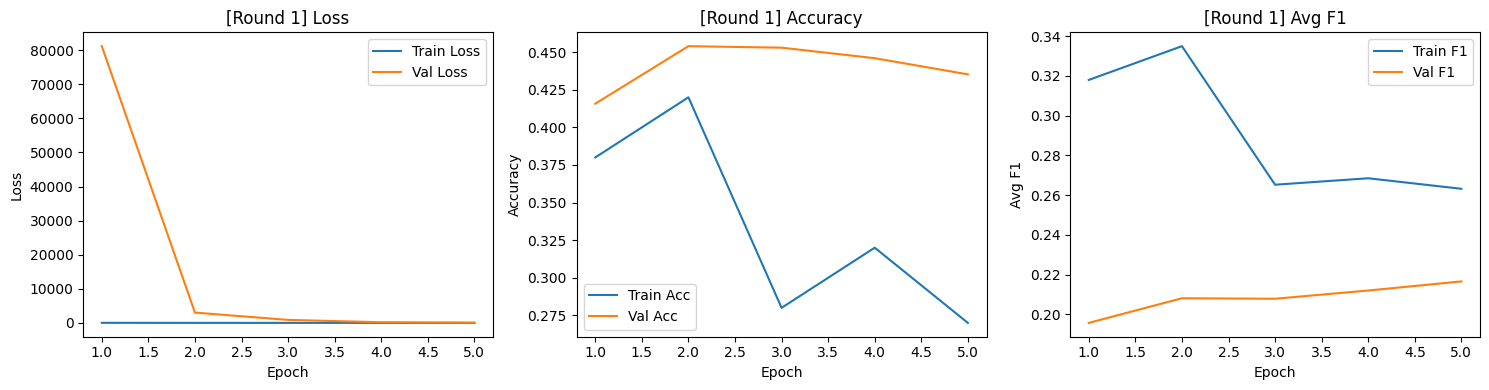


[AL Round 1/4] — Labeled samples: 110



Epoch 5/5
Train — Loss: 1.4007 | Acc: 0.3182 | Avg F1: 0.3107
Val   — Loss: 3.7318 | Acc: 0.3917 | Avg F1: 0.3702


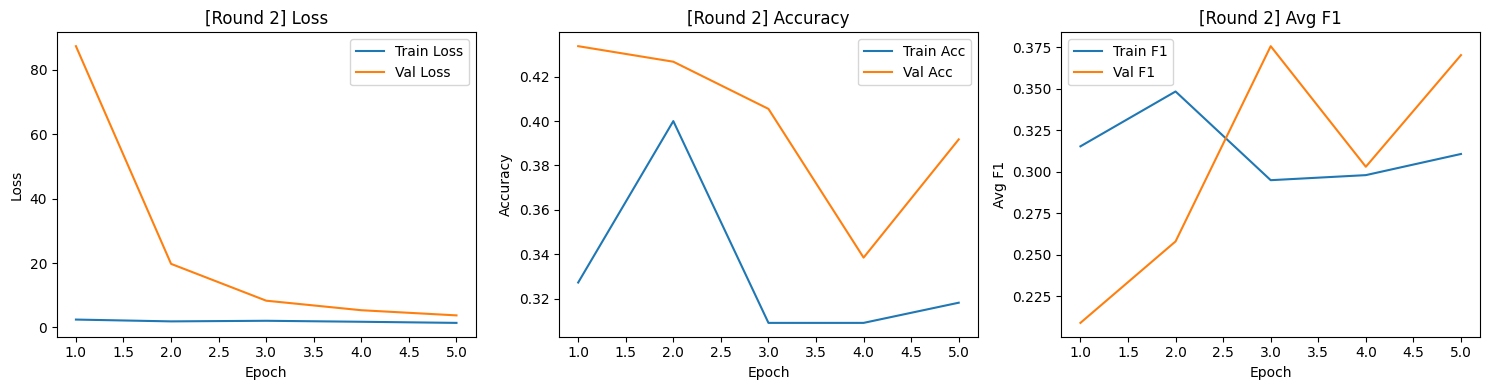


[AL Round 2/4] — Labeled samples: 120



Epoch 5/5
Train — Loss: 1.5016 | Acc: 0.3583 | Avg F1: 0.3397
Val   — Loss: 1.7232 | Acc: 0.3550 | Avg F1: 0.2462


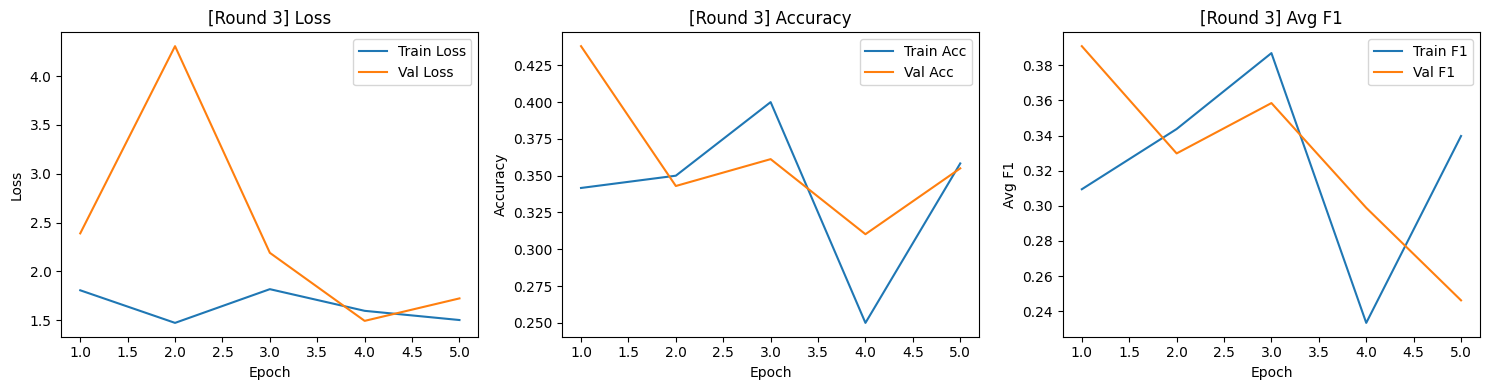


[AL Round 3/4] — Labeled samples: 130



Epoch 5/5
Train — Loss: 2.4398 | Acc: 0.4615 | Avg F1: 0.2852
Val   — Loss: 3.5607 | Acc: 0.4537 | Avg F1: 0.2534


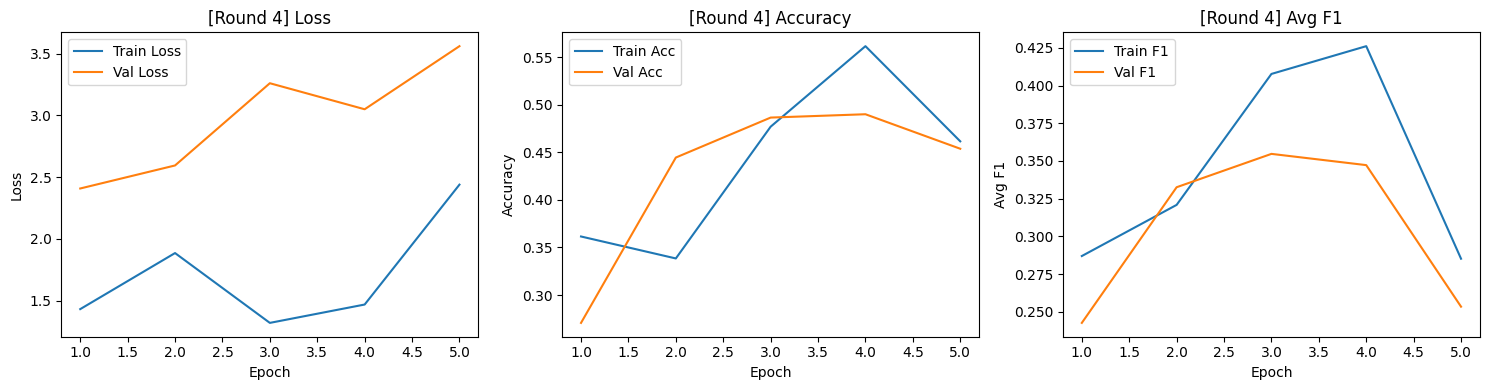


[AL Round 4/4] — Labeled samples: 140



Epoch 10/10
Train — Loss: 1.2395 | Acc: 0.5143 | Avg F1: 0.4203
Val   — Loss: 1.1189 | Acc: 0.4365 | Avg F1: 0.3191


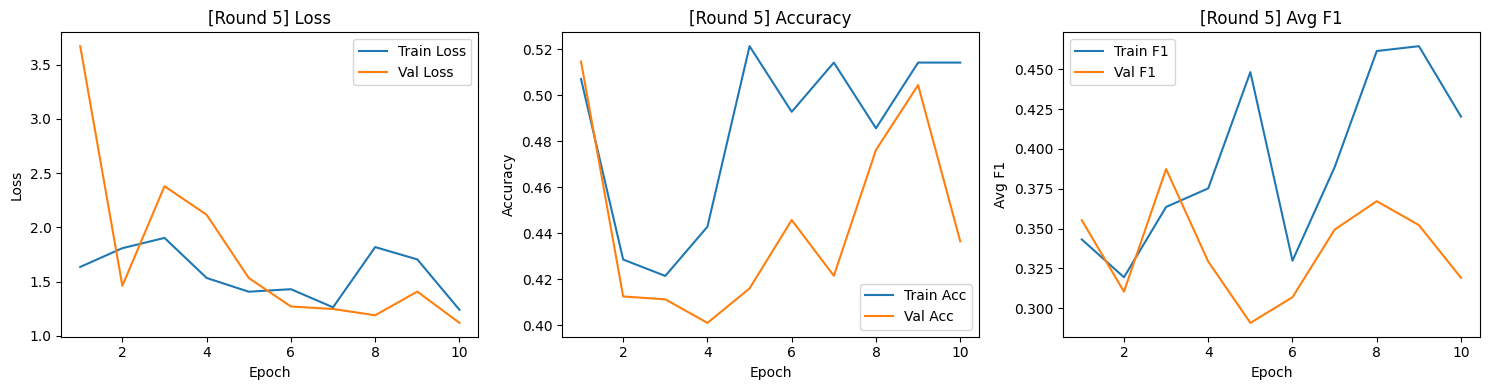

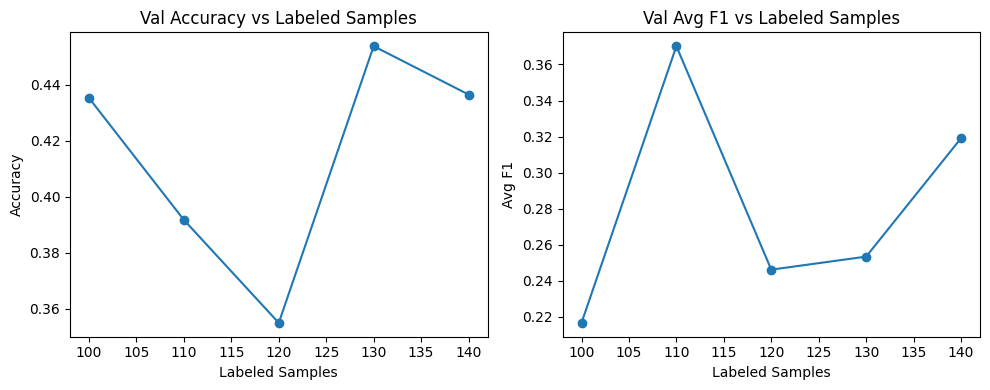

X_labeled shape: (300, 6, 28)
y_labeled shape: (300,)
Distribution in X_labeled:
  Class 0: 136 (45.3%)
  Class 1: 39 (13.0%)
  Class 2: 125 (41.7%)
X_unlabeled shape: (15700, 6, 28)
y_unlabeled shape: (15700,)
Distribution in X_unlabeled:
  Class 0: 7129 (45.4%)
  Class 1: 2043 (13.0%)
  Class 2: 6528 (41.6%)

=== Running strategy: MARGIN ===

[AL Round 0/9] — Labeled samples: 300



Epoch 5/5
Train — Loss: 1.2980 | Acc: 0.3800 | Avg F1: 0.3793
Val   — Loss: 1.1193 | Acc: 0.3440 | Avg F1: 0.2926


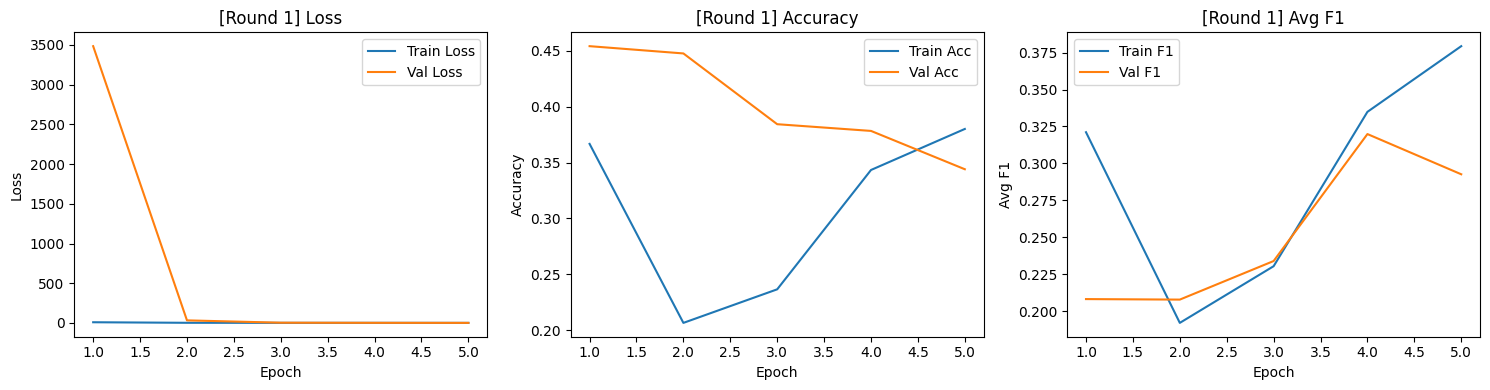


[AL Round 1/9] — Labeled samples: 310



Epoch 5/5
Train — Loss: 1.1881 | Acc: 0.4129 | Avg F1: 0.3996
Val   — Loss: 1.1735 | Acc: 0.3620 | Avg F1: 0.3391


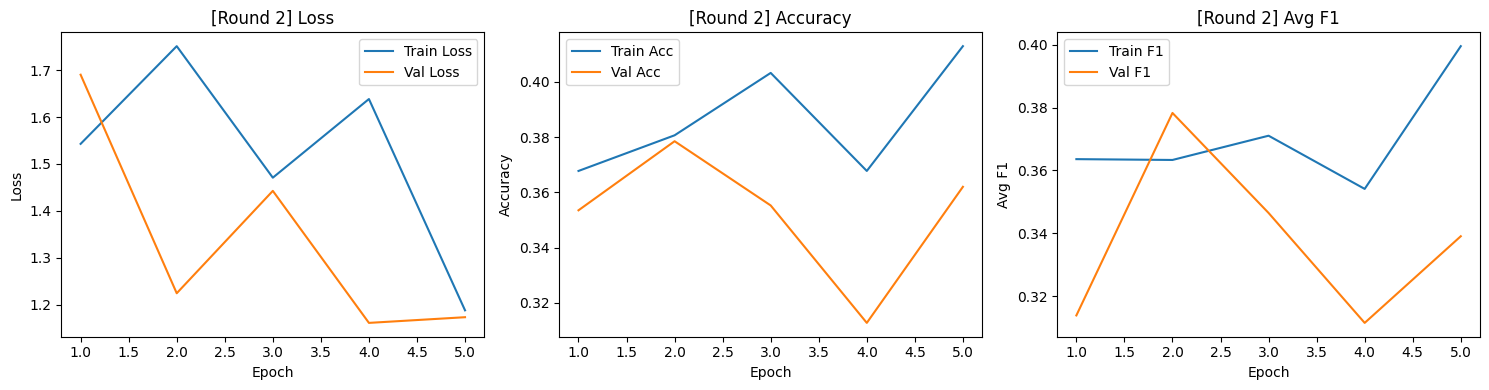


[AL Round 2/9] — Labeled samples: 320



Epoch 5/5
Train — Loss: 1.0443 | Acc: 0.4562 | Avg F1: 0.4479
Val   — Loss: 0.9779 | Acc: 0.5387 | Avg F1: 0.5320


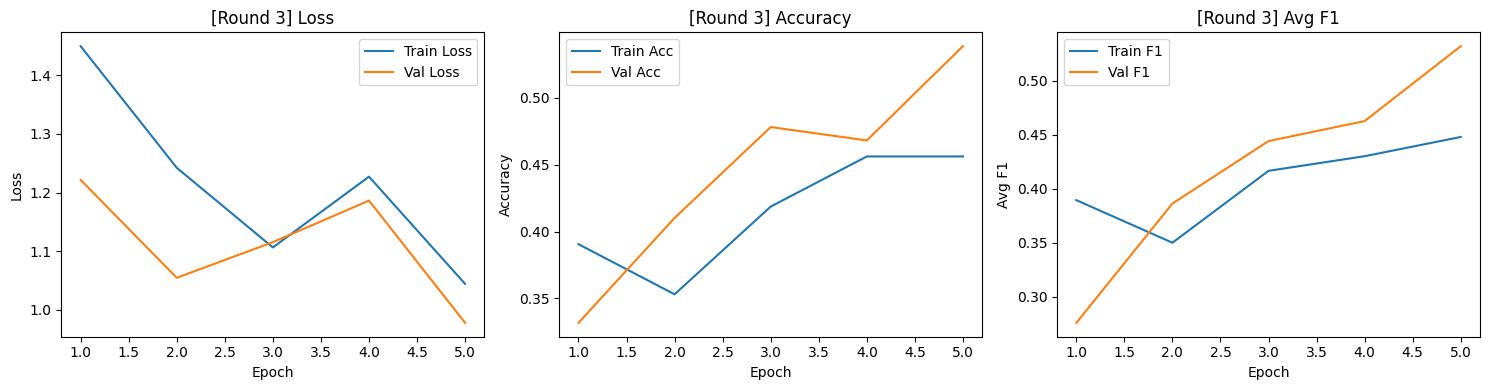


[AL Round 3/9] — Labeled samples: 330



Epoch 5/5
Train — Loss: 0.9092 | Acc: 0.5152 | Avg F1: 0.5125
Val   — Loss: 0.8838 | Acc: 0.5575 | Avg F1: 0.5541


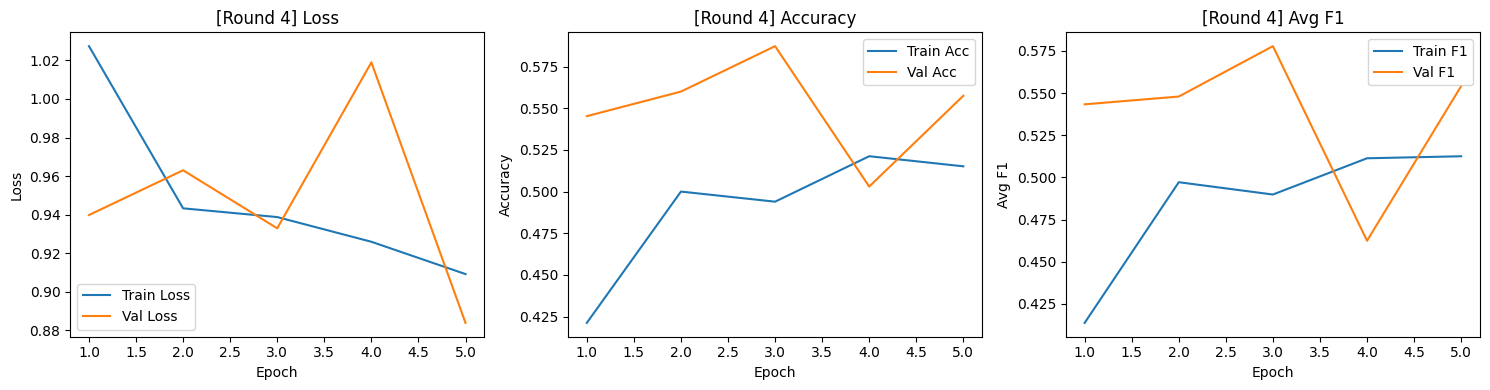


[AL Round 4/9] — Labeled samples: 340



Epoch 10/10
Train — Loss: 0.7823 | Acc: 0.6588 | Avg F1: 0.6387
Val   — Loss: 0.7953 | Acc: 0.6188 | Avg F1: 0.5989


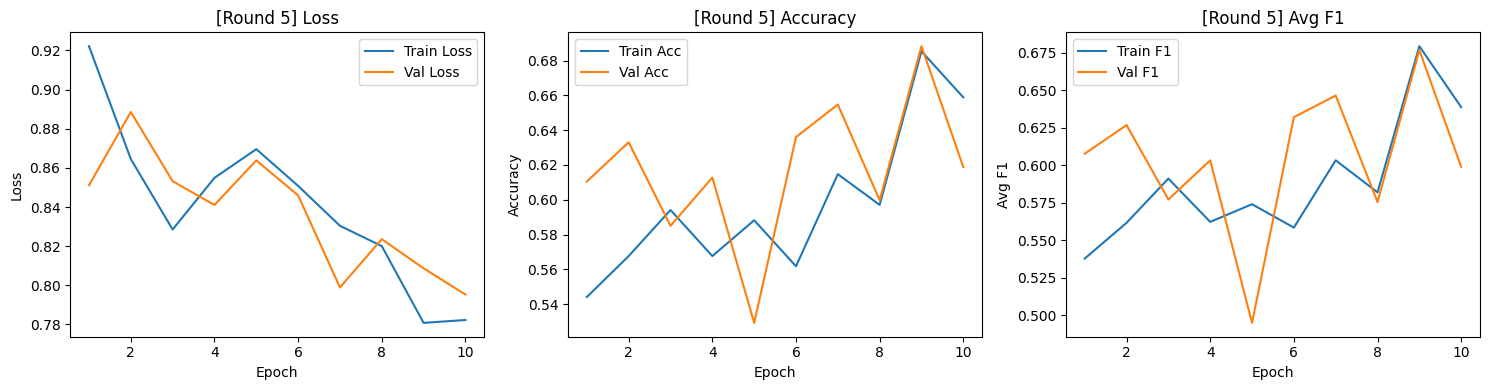


[AL Round 5/9] — Labeled samples: 350



Epoch 10/10
Train — Loss: 0.7177 | Acc: 0.7143 | Avg F1: 0.7053
Val   — Loss: 0.7558 | Acc: 0.6825 | Avg F1: 0.6662


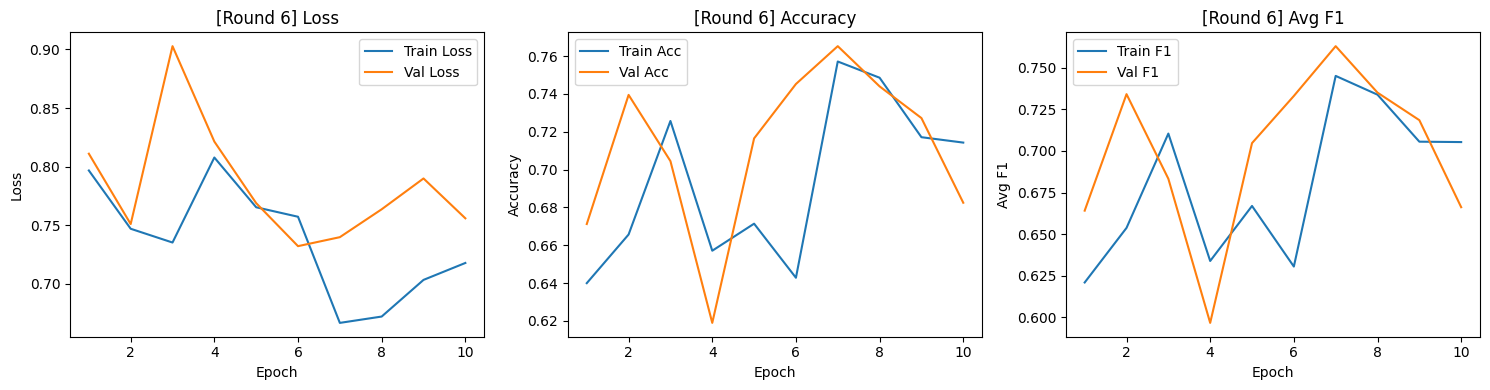


[AL Round 6/9] — Labeled samples: 360


Epoch:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

In [ ]:
all_histories = {}

for initial_labeled, iters,query_size in data:

    if resume and os.path.exists(checkpoint_path):
        initial_labeled = load_checkpoint_data(checkpoint_path)
    
    initial_labeled= 1-initial_labeled/len(X_pool)
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)
    print(f"X_labeled shape: {X_labeled.shape}")
    print(f"y_labeled shape: {y_labeled.shape}")
    print_distribution(y_labeled, name="X_labeled")
    print(f"X_unlabeled shape: {X_unlabeled.shape}")
    print(f"y_unlabeled shape: {y_unlabeled.shape}")
    print_distribution(y_unlabeled, name="X_unlabeled")

    
    labeled_dataset = Dataset(X_labeled, y_labeled)
    unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
    val_dataset = Dataset(X_val, y_val)

    
    
    for strat in strategies:
        print(f"\n=== Running strategy: {strat.upper()} ===")
        
        # Reset datasets to initial versions (deepcopy to avoid mutations)
        labeled = copy.deepcopy(labeled_dataset)
        unlabeled = copy.deepcopy(unlabeled_dataset)
    
        model.load_state_dict(copy.deepcopy(initial_state_dict))
        
        hist = active_learning_loop(
            model,
            labeled_dataset=labeled,
            unlabeled_dataset=unlabeled,
            val_dataset=val_dataset,
            strategy=strat,
            device=device,
            iters=iters,
            query_size=query_size,
            final_epochs=epochs,
            loss_mode=loss_mode,
            batch_size=batch_size
        )
        
        all_histories[(strat, initial_labeled, iters, query_size)] = hist



# Plotting final result

In [ ]:
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init + query * iterations

unique_configs = sorted(set((init_size, iters, query) for (_, init_size, iters, query) in all_histories.keys()))

for init_size, iters, query in unique_configs:
    plt.figure(figsize=(12, 5))

    effective_init = round(len(X_pool) * (1 - init_size))
    samples_used = total_labeled_samples(effective_init, iters, query)
    eff_samples_used = eff_total_labeled_samples(effective_init, iters, query)

    plt.suptitle(
        f"Init: {effective_init}, Iters: {iters}, Query: {query}, "
        f"Samples Used: {samples_used}, Eff Samples: {eff_samples_used}",
        fontsize=14
    )

    # Accuracy
    plt.subplot(1, 2, 1)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            samples = [r["num_labeled_samples"] for r in hist["rounds"]]
            val_acc = [r["final_val"]["acc"] for r in hist["rounds"]]
            plt.plot(samples, val_acc, label=strat, marker='o')

            # Annotate final value
            x_final, y_final = samples[-1], val_acc[-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')

    plt.title("Validation Accuracy")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1, 2, 2)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            samples = [r["num_labeled_samples"] for r in hist["rounds"]]
            val_f1 = [r["final_val"]["avg_f1"] for r in hist["rounds"]]
            plt.plot(samples, val_f1, label=strat, marker='o')

            # Annotate final value
            x_final, y_final = samples[-1], val_f1[-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')

    plt.title("Validation Avg F1")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1 Score")
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
